In [5]:
import pandas as pd
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import medchem as mc
RDLogger.DisableLog('rdApp.*')

def get_isomer(inchi):
    mol = Chem.MolFromInchi(inchi)
    isomers = tuple(EnumerateStereoisomers(mol))
    isomers = sorted(Chem.MolToInchi(i) for i in isomers)
    return isomers[0]

def replace_first_space(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            first_space_index = line.find(' ')
            modified_line = line[:first_space_index] + ';' + line[first_space_index + 1:]
            outfile.write(modified_line)

def eli_lilly_filter(flagreason: str):
    rules = [
        "no_interesting_atoms",
        "too_few_rings",
        "too_many_rings",
        "biotin",
        "too_many_aromatic_rings_in_ring_system",
        "ring_system_too_large",
        "ring_system_too_large_with_aromatic",
        "fmoc",
        "positive",
        "negative",
        "too_long_carbon_chain",
        "diphosphate",
        "quaternary_amine",
        "sulfonic_acid",
        "quaternary_amine",
        "crown_2_2_cyclic",
        "crown_3_3_cyclic",
        "crown_2_3_cyclic",
        "crown_2_2",
        "crown_3_3",
        "crown_2_3",
        "phenylenediamine",
        "LongCChain"
             ]
    for i in rules:
        if i in flagreason:
            return None
    return 0

In [6]:
replace_first_space("./original_outputs/bad0.smi", "./parsed_outputs/parsed_smi_0.smi")
replace_first_space("./original_outputs/bad1.smi", "./parsed_outputs/parsed_smi_1.smi")
replace_first_space("./original_outputs/bad2.smi", "./parsed_outputs/parsed_smi_2.smi")
replace_first_space("./original_outputs/bad3.smi", "./parsed_outputs/parsed_smi_3.smi")
replace_first_space("./original_outputs/good.smi", "./parsed_outputs/good.smi")

In [7]:
df0 = pd.read_csv("./parsed_outputs/parsed_smi_0.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df1 = pd.read_csv("./parsed_outputs/parsed_smi_1.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df2 = pd.read_csv("./parsed_outputs/parsed_smi_2.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df3 = pd.read_csv("./parsed_outputs/parsed_smi_3.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])
df4 = pd.read_csv("./parsed_outputs/good.smi",
                  delimiter=";", names=["SMILES", "FlagReason"])

df_pos = pd.concat([df0, df1, df2, df3])
df_pos["pred"] = 1
df_neg = df4
df_neg["pred"] = 0
df = pd.concat([df_pos, df_neg])
df

,SMILES,FlagReason,pred
0,C=CCN=C=S,TP1 not_enough_atoms,1
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1
2,C(Cl)C1OC1,TP1 not_enough_atoms,1
3,C(Br)C1OC1,TP1 not_enough_atoms,1
4,C(F)C1OC1,TP1 not_enough_atoms,1
...,...,...,...
143,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0
144,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0
145,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0
146,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0


In [8]:
df["remove"] = df.FlagReason.apply(eli_lilly_filter)
df = df.dropna().drop("remove", axis=1)
df["InChI"] = df.SMILES.apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
df["InChI"] = df.InChI.apply(get_isomer)
df

,SMILES,FlagReason,pred,InChI
0,C=CCN=C=S,TP1 not_enough_atoms,1,"InChI=1S/C4H5NS/c1-2-3-5-4-6/h2H,1,3H2"
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1,InChI=1S/C31H29ClFN5O3/c32-22-8-2-6-18-5-1-7-2...
2,C(Cl)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5ClO/c4-1-3-2-5-3/h3H,1-2H2"
3,C(Br)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5BrO/c4-1-3-2-5-3/h3H,1-2H2"
4,C(F)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5FO/c4-1-3-2-5-3/h3H,1-2H2"
...,...,...,...,...
143,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0,InChI=1S/C8H12O2/c1-2-6-8(10-6)4-3-7-5(1)9-7/h...
144,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0,InChI=1S/C15H12N2O2/c16-15(18)17-11-7-3-1-5-9(...
145,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0,InChI=1S/C21H21NO/c1-22-12-10-14(11-13-22)19-1...
146,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0,InChI=1S/C8H6N2O/c11-8-5-9-6-3-1-2-4-7(6)10-8/...


In [9]:
test_data_df = pd.read_csv("../data/SMILES_test/test_data_all.csv")
test_data_df["InChI"] = test_data_df.SMILES.apply(lambda x: Chem.MolToInchi(Chem.MolFromSmiles(x)))
test_data_df["InChI"] = test_data_df.InChI.apply(get_isomer)
test_data_df = test_data_df[["InChI", "warhead_category", "covalent", "SMILES"]]

In [10]:
df_final = df.merge(test_data_df, how="left", on=["InChI"])
df_final["mol"] = df_final.SMILES_x.apply(Chem.MolFromSmiles)
df_final["alerts_PAINS"] = mc.functional.alert_filter(
    mols=df_final["mol"].tolist(),
    alerts=["PAINS"],
    n_jobs=-1,
    progress=True,
    return_idx=False,
).astype(int)
df_final["alerts_PAINS"] = df_final.alerts_PAINS.replace({0:1, 1:0})

df_final["filters_NIBR"] = mc.functional.nibr_filter(
    mols=df_final["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
).astype(int)
df_final["filters_NIBR"] = df_final.filters_NIBR.replace({0:1, 1:0})

df_final = df_final.dropna()
df_final

Common alerts filtering:   0%|          | 0/609 [00:00<?, ?it/s]

NIBR filtering:   0%|          | 0/609 [00:00<?, ?it/s]

,SMILES_x,FlagReason,pred,InChI,warhead_category,covalent,SMILES_y,mol,alerts_PAINS,filters_NIBR
0,C=CCN=C=S,TP1 not_enough_atoms,1,"InChI=1S/C4H5NS/c1-2-3-5-4-6/h2H,1,3H2",thiocyanate,1.0,[H]C([H])=C([H])C([H])([H])N=C=S,<rdkit.Chem.rdchem.Mol object at 0x3208636f0>,0,1
1,C1=CC(Cl)=C2C(=CC=CC2=C1)C1=NC=C2C(=NC(=NC2=C1...,TP1 too_many_atoms,1,InChI=1S/C31H29ClFN5O3/c32-22-8-2-6-18-5-1-7-2...,lactone,1.0,[H]c1c([H])c(Cl)c2c(-c3nc([H])c4c(N5C([H])([H]...,<rdkit.Chem.rdchem.Mol object at 0x3208a6260>,0,0
2,C(Cl)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5ClO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(Cl)C1([H])OC1([H])[H],<rdkit.Chem.rdchem.Mol object at 0x3208a61f0>,0,1
3,C(Br)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5BrO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(Br)C1([H])OC1([H])[H],<rdkit.Chem.rdchem.Mol object at 0x3208a6180>,0,1
4,C(F)C1OC1,TP1 not_enough_atoms,1,"InChI=1S/C3H5FO/c4-1-3-2-5-3/h3H,1-2H2",epoxide,1.0,[H]C([H])(F)C1([H])OC1([H])[H],<rdkit.Chem.rdchem.Mol object at 0x3208a5f50>,0,0
...,...,...,...,...,...,...,...,...,...,...
604,C1C[C@@H]2O[C@@H]2CC[C@H]2O[C@@H]12,: D(50) het_3mem_ring_fused,0,InChI=1S/C8H12O2/c1-2-6-8(10-6)4-3-7-5(1)9-7/h...,noncovalentdecoy,0.0,[H]C1([H])C([H])([H])[C@]2([H])O[C@]2([H])C([H...,<rdkit.Chem.rdchem.Mol object at 0x320a2f140>,0,0
605,NC(=O)N1C2=CC=CC=C2[C@@H]2O[C@@H]2C2=CC=CC=C12,: D(50) het_3mem_ring_fused,0,InChI=1S/C15H12N2O2/c16-15(18)17-11-7-3-1-5-9(...,noncovalentdecoy,0.0,[H]N=C(O[H])N1c2c([H])c([H])c([H])c([H])c2[C@]...,<rdkit.Chem.rdchem.Mol object at 0x320a2f1b0>,0,1
606,C1=CC=C2C(=C1)C(=C1CCN(C)CC1)C1=CC=CC=C1[C@H]1...,: D(50) het_3mem_ring_fused,0,InChI=1S/C21H21NO/c1-22-12-10-14(11-13-22)19-1...,noncovalentdecoy,0.0,[H]c1c([H])c([H])c2c(c1[H])C(=C1C([H])([H])C([...,<rdkit.Chem.rdchem.Mol object at 0x320a2f220>,1,1
607,C1=CC=C2C(=C1)N=CC(=O)N2,C1=CC=C2C(=C1)N=CC(=O)N2,0,InChI=1S/C8H6N2O/c11-8-5-9-6-3-1-2-4-7(6)10-8/...,noncovalentdecoy,0.0,[H]c1c([H])c([H])c2c(nc([H])c(=O)n2[H])c1[H],<rdkit.Chem.rdchem.Mol object at 0x320a2f290>,0,0


### Why does eli lilly generate new structures?

In [11]:
test_inchies = set(test_data_df.InChI.values)
eli_inchies = set(df.InChI.values)
to_remove = test_inchies.intersection(eli_inchies)

test_inchies = sorted(list(test_inchies - to_remove))
eli_inchies = sorted(list(eli_inchies - to_remove))


In [12]:
eli_inchies[0], test_inchies[0]

('InChI=1S/C15H11N3O3S2/c19-12-8(13-18(12)10(6-22-13)14(20)21)4-7-5-17-9-2-1-3-11(9)23-15(17)16-7/h4-6,13H,1-3H2,(H,20,21)/b8-4+',
 'InChI=1S/C12H10ClN5O/c1-18-3-4-2-5(12(16)19)17-10-6(4)11(18)9(15)7(13)8(10)14/h2-3H,1H3,(H5,14,15,16,19)/p+1')

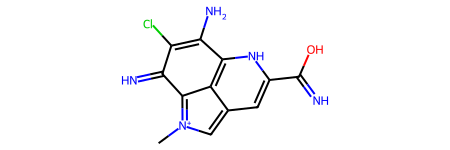

In [13]:
# Chem.MolFromInchi(eli_inchies[0])
Chem.MolFromInchi(test_inchies[0])

### Eli Lilly metrics 

In [14]:
(
    precision_score(df_final.covalent, df_final.pred),
    recall_score(df_final.covalent, df_final.pred),
    f1_score(df_final.covalent, df_final.pred),
    1 - accuracy_score(
        df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
        df_final.query("warhead_category == 'noncovalentdecoy'").pred,
                    )
)


(0.8066666666666666,
 0.8746987951807229,
 0.8393063583815028,
 0.7446808510638299)

### PAINS Metrics

In [15]:
(
    precision_score(df_final.covalent, df_final.alerts_PAINS),
    recall_score(df_final.covalent, df_final.alerts_PAINS),
    f1_score(df_final.covalent, df_final.alerts_PAINS),
    1 - accuracy_score(
        df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
        df_final.query("warhead_category == 'noncovalentdecoy'").alerts_PAINS,
                    )
)


(0.8333333333333334,
 0.03614457831325301,
 0.06928406466512702,
 0.021276595744680882)

### NIBR Metrics

In [16]:
(
    precision_score(df_final.covalent, df_final.filters_NIBR),
    recall_score(df_final.covalent, df_final.filters_NIBR),
    f1_score(df_final.covalent, df_final.filters_NIBR),
    1 - accuracy_score(
        df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
        df_final.query("warhead_category == 'noncovalentdecoy'").filters_NIBR,
                    )
)


(0.788235294117647, 0.1614457831325301, 0.268, 0.2978723404255319)

### GNN metrics

In [17]:
import tensorflow as tf
import math
from helpers import encoder
model_file = "../saved_models/GCNII"
model = tf.keras.models.load_model(model_file)
gnn_pred = model.predict(encoder(df_final.mol.values))

Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit

19/19 [==============================] - 5s 9ms/step


In [18]:
cutoff = 0.3
df_final["gnn_pred"] = gnn_pred
# df_final["gnn_pred"] = df_final.gnn_pred.apply(lambda x: math.ceil(x) if x > cutoff else math.floor(x))

In [19]:
len(df_final.query("pred == 1.0")), len(df_final.query("gnn_pred == 1.0")), len(df_final.query("covalent == 1.0"))

(450, 0, 415)

In [20]:
len(set(df_final.query("pred == 1.0").index).intersection(set(df_final.query("gnn_pred == 1.0").index)))

0

Fraction of true eli lilly in GNN_pred < 0.10: 82.00000
Fraction of true eli lilly in GNN_pred < 0.20: 29.00000
Fraction of true eli lilly in GNN_pred < 0.30: 13.00000
Fraction of true eli lilly in GNN_pred < 0.40: 17.00000
Fraction of true eli lilly in GNN_pred < 0.50: 18.00000
Fraction of true eli lilly in GNN_pred < 0.60: 6.00000
Fraction of true eli lilly in GNN_pred < 0.70: 15.00000
Fraction of true eli lilly in GNN_pred < 0.80: 24.00000
Fraction of true eli lilly in GNN_pred < 0.90: 29.00000
Fraction of true eli lilly in GNN_pred < 1.00: 217.00000


([<matplotlib.axis.XTick at 0x37f1c53f0>,
 [Text(0.0, 0, '(0.0, 0.1)'),
  Text(0.1, 0, '(0.1, 0.2)'),
  Text(0.2, 0, '(0.2, 0.3)'),
  Text(0.30000000000000004, 0, '(0.3, 0.4)'),
  Text(0.4, 0, '(0.4, 0.5)'),
  Text(0.5, 0, '(0.5, 0.6)'),
  Text(0.6000000000000001, 0, '(0.6, 0.7)'),
  Text(0.7000000000000001, 0, '(0.7, 0.8)'),
  Text(0.8, 0, '(0.8, 0.9)'),
  Text(0.9, 0, '(0.9, 0.10)')])

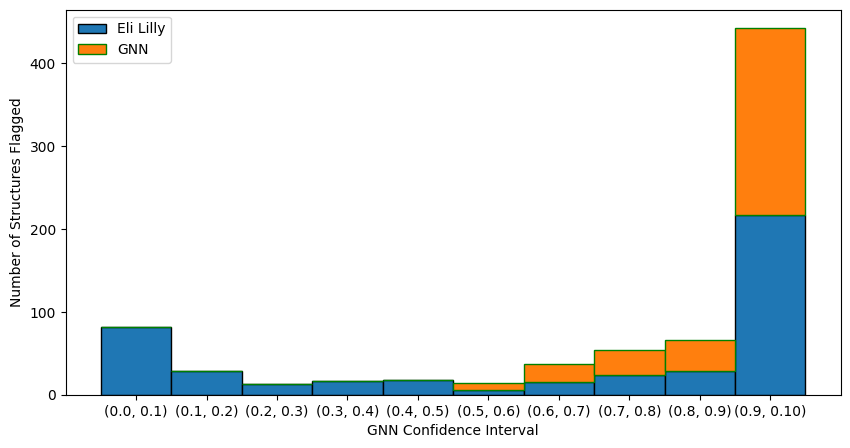

In [23]:
import numpy as np
import matplotlib.pyplot as plt
ranges = np.arange(0, 1.1, 0.1)

props = []
gnn = []
for i in ranges:
    df_gnn_range = df_final.query(f"gnn_pred <= {i} and gnn_pred > {i-0.1}")
    if df_gnn_range.empty:
        continue
    # eli_lilly_true_frac = df_gnn_range.query("pred == 1.0").shape[0] / df_gnn_range.shape[0]
    eli_lilly_true_frac = df_gnn_range.query("pred == 1.0").shape[0]
    gnn_true = df_gnn_range.query("gnn_pred > 0.5").shape[0]
    props.append(eli_lilly_true_frac)
    gnn.append(gnn_true)
    print(f"Fraction of true eli lilly in GNN_pred < {i:.2f}: {eli_lilly_true_frac:.5f}")

# plot a stacked bar chart with GNN values
plt.figure(figsize=(10, 5))
plt.bar(ranges[:-1], props, width=0.1, edgecolor='black', label='Eli Lilly True')
plt.bar(ranges[:-1], gnn, width=0.1, edgecolor='green', bottom=props, label='GNN True')

plt.xlabel("GNN Confidence Interval")
plt.ylabel("Number of Structures Flagged")
plt.legend()

plt.xticks(ranges[:-1], [f"(0.{i}, 0.{i+1})" for i in range(10)])
# plt.title("ChEMBL Fraction of True Eli Lilly vs GNN Confidence")

In [47]:
(
    precision_score(df_final.covalent, df_final.gnn_pred),
    recall_score(df_final.covalent, df_final.gnn_pred),
    f1_score(df_final.covalent, df_final.gnn_pred),
)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
1 - accuracy_score(
    df_final.query("warhead_category == 'noncovalentdecoy'").covalent,
    df_final.query("warhead_category == 'noncovalentdecoy'").gnn_pred,
                   )